# Classifying Columbia University landmarks using neural networks

**by Jacqueline Araya**

In this notebook I use transfer learning to build a neural network model based on a well known CNN architecture, [VGG16](https://neurohive.io/en/popular-networks/vgg16/), that classifies with high accuracy any image of 3 popular Columbia University in the city of New York landmarks:



*   [Alma Mater](https://en.wikipedia.org/wiki/Alma_Mater_(New_York_sculpture)) 

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/a/ac/2014_Columbia_University_Alma_Mater_closeup.jpg/425px-2014_Columbia_University_Alma_Mater_closeup.jpg" width="150">


*   [Scholars` Lion](http://www.wikicu.com/Scholar%27s_Lion)     

<img src="http://www.wikicu.com/images/2/2c/ScholarsLion.jpg" width="200">


*  [The Curl in Uris Hall](https://blogs.cul.columbia.edu/outdoorsculpture/2015/12/22/meadmores-curl-conservation-complete/)


 <img src="https://blogs.cul.columbia.edu/outdoorsculpture/files/2015/12/curl_20151219-500x333.jpg" width="200">




---



### Import Tensorflow 2.0 and other libraries

In [ ]:
try:
  %tensorflow_version 2.x # enable TF 2.x in Colab
except Exception:
  pass

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x # enable TF 2.x in Colab`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [ ]:
import IPython.display as display
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import pathlib
import glob
import os, shutil
from PIL import Image, ExifTags
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import datasets, layers, models

### Some model specifications

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32
IMG_SIZE = 256
SHUFFLE_SIZE = 1000

### Connect to Google Drive to download dataset of images and unzip to local folder

In [ ]:
# Connect to Google Drive (to load raw data)
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
files_name = {'dataset_columbia.tar.gz': '1NAQ7MSbyAcMidMwLQfJ0pIYmhu161awF'}

for key, value in files_name.items():
  downloaded = drive.CreateFile({'id': value, 
                                'title': key})
  print("Downloading {} file ...".format(key))
  downloaded.GetContentFile(key)

In [ ]:
#Untar locally Columbia Dataset
!pwd
!tar -zxf "dataset_columbia.tar.gz"

/content


In [ ]:
!rm -rf "dataset_columbia.tar.gz"

In [ ]:
base_dir = "dataset_columbia/"
base_dir_path = pathlib.Path(base_dir)

photo_paths = list(base_dir_path.glob('*/*'))
photo_paths = [str(path) for path in photo_paths]
random.shuffle(photo_paths)

labels = list(base_dir_path.glob('*/'))
labels = [str(path).replace(base_dir,'') for path in labels]

Check the paths to images and the labels

In [ ]:
photo_paths[:5]

['dataset_columbia/uris/20191004_183131_013.jpg',
 'dataset_columbia/uris/20191006_124543.jpg',
 'dataset_columbia/uris/20191004_170254.jpg',
 'dataset_columbia/uris/20191004_183103_003.jpg',
 'dataset_columbia/alma_matter/20191004_183459_031.jpg']

In [ ]:
labels

['uris', 'alma_matter', 'lion']

How many images are there to train the model?

In [ ]:
n_photos = len(photo_paths)
n_photos

600

Let's display some images from the loaded files:

In [ ]:
for n in range(3):
  image_path = random.choice(photo_paths)
  display.display(display.Image(image_path, width = 285, height = 275)) #resize images to display
  print()

Output hidden; open in https://colab.research.google.com to view.

### Preprocessing raw images

The original photos (taken by me) are rotated internally because they were taken with a smartphone in a vertical way, therefore I'll use a function to change the original rotation of an image

In [ ]:
def load_and_preprocess_image(path):
  '''
  Input: path of location of image
  Output: image modified and saved on same path, no return
  '''
  try:
    image=Image.open(path)
    for orientation in ExifTags.TAGS.keys():
        if ExifTags.TAGS[orientation]=='Orientation':
            break

    exif=dict(image._getexif().items())

    if exif[orientation] == 3:
        image=image.rotate(180, expand=True)
    elif exif[orientation] == 6:
        image=image.rotate(270, expand=True)
    elif exif[orientation] == 8:
        image=image.rotate(90, expand=True)

    image.save(path)
    image.close()
  except (AttributeError, KeyError, IndexError):
    # cases: image don't have getexif
    pass

Once the function is applied the jpg files are modified locally

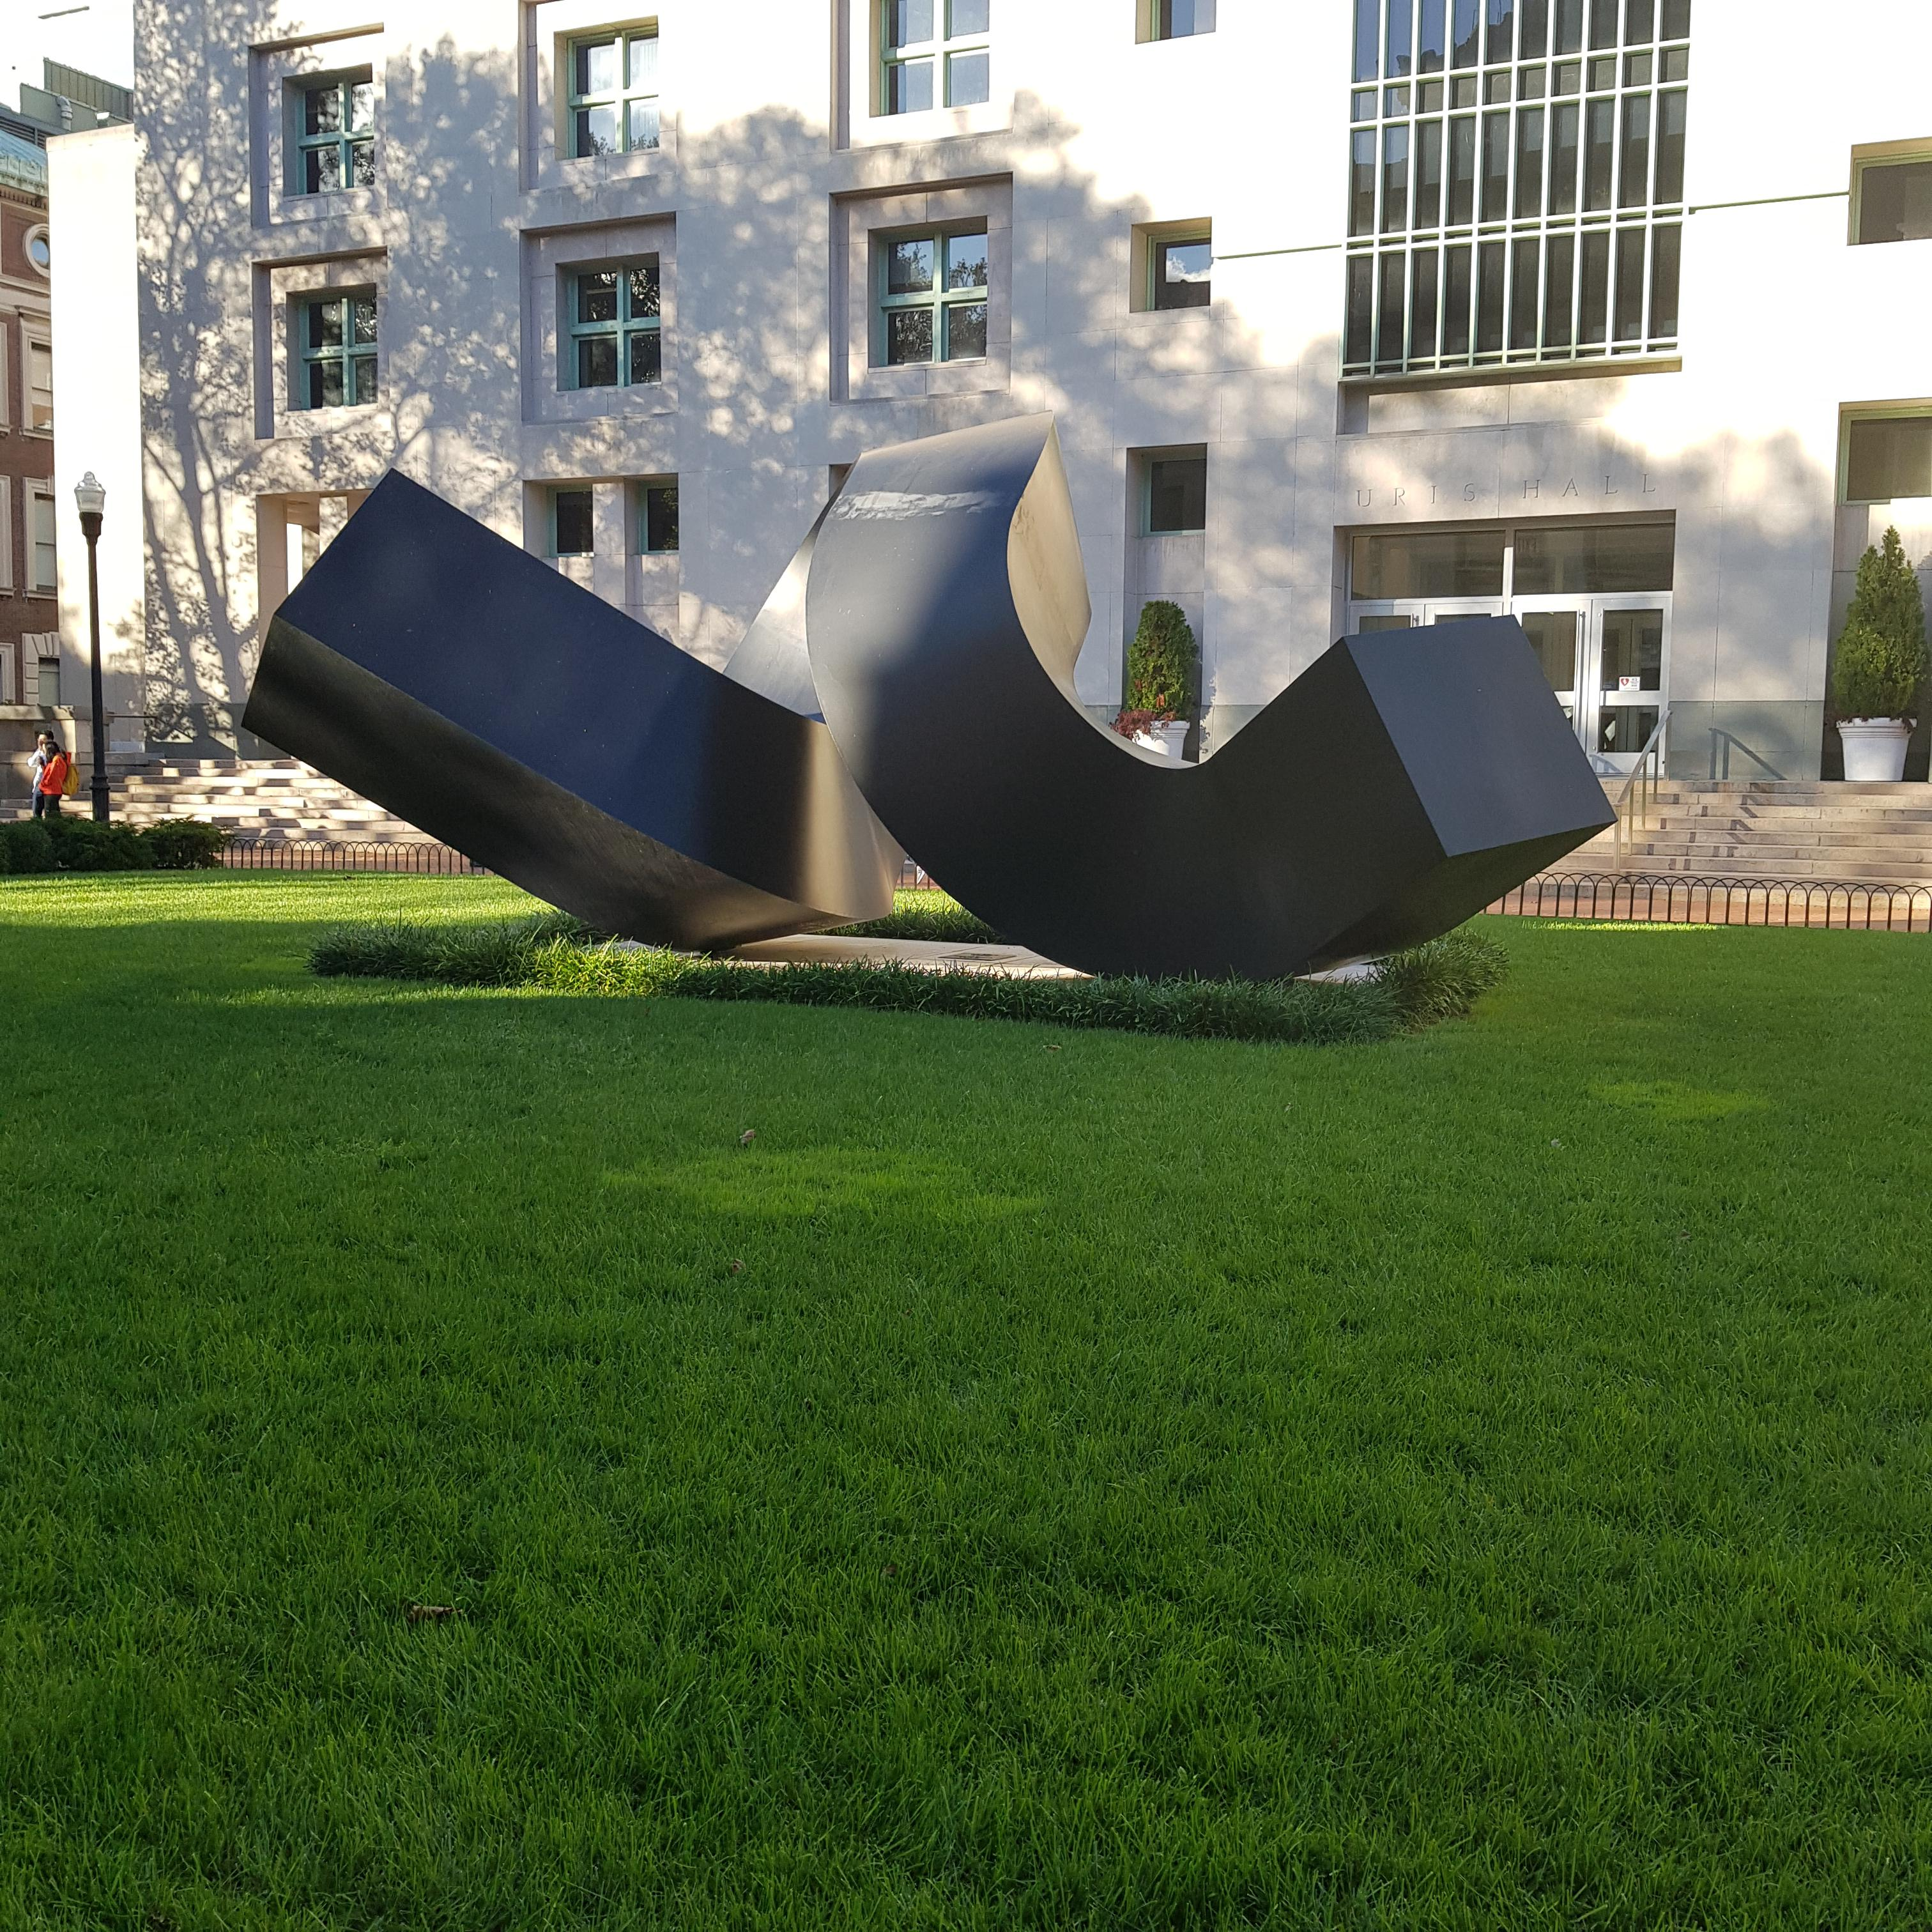

In [ ]:
result =  load_and_preprocess_image(photo_paths[2])
display.display(display.Image(photo_paths[2], width = 385, height = 375))

### Create a Train/Test split of the images paths

Create train and test splits using Sklearn library

In [ ]:
#split train/test for processed images
from sklearn.model_selection import train_test_split
train_paths, test_paths = train_test_split(photo_paths)

In [ ]:
len(train_paths), len(test_paths)

(450, 150)

* Train images: 450 
* Test images: 150

Preprocess images and copy them to the Train or Test folder according to the Train/Test separation

In [ ]:
#Create separate directories to get a train and a test dataset

#Split base_dir_path (images pahts) into train and test folders
train_dir = 'train'
if not os.path.exists(train_dir):
  os.mkdir(train_dir)

test_dir = 'test'
if not os.path.exists(test_dir):
  os.mkdir(test_dir)

for l in labels:
  train_label_dir = os.path.join(train_dir, l)
  if not os.path.exists(train_label_dir):
    os.mkdir(train_label_dir)
  test_label_dir = os.path.join(test_dir, l)
  if not os.path.exists(test_label_dir):
    os.mkdir(test_label_dir)
  
#Copy images to each corresponding folder while processing them
for p in train_paths:
  aux = os.path.basename(p)
  photo_label = p[len(base_dir):-(len(aux)+1)]
  dest = 'train/%s/%s'%(photo_label,aux)
  load_and_preprocess_image(p)
  shutil.copyfile(p, dest)

for p in test_paths:
  aux = os.path.basename(p)
  photo_label = p[len(base_dir):-(len(aux)+1)]
  dest = 'test/%s/%s'%(photo_label,aux)
  load_and_preprocess_image(p)
  shutil.copyfile(p, dest)


In [ ]:
train_dir_path = pathlib.Path(train_dir)
test_dir_path = pathlib.Path(test_dir)

### Image generators

Use ImageDataGenerator from TF to create a generator that rescale images and create batches of images to feed to the model when training

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir_path,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=32,
        shuffle=True,
        class_mode = "sparse")

test_generator = test_datagen.flow_from_directory(
        test_dir_path,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=32,
        class_mode = "sparse")

for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break
    
for data_batch, labels_batch in test_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

Found 450 images belonging to 3 classes.
Found 150 images belonging to 3 classes.
data batch shape: (32, 256, 256, 3)
labels batch shape: (32,)
data batch shape: (32, 256, 256, 3)
labels batch shape: (32,)


Check the generator works well with a batch of images

In [87]:
sample_training_images, sample_train_labels = next(train_generator)

In [88]:
sample_labels[:5]

array([2., 1., 0., 0., 2.], dtype=float32)

In [90]:
train_generator.class_indices
inverse_class = {v:k for k, v in train_generator.class_indices.items()}

In [83]:
def plotImages(images_sample, labels_sample, class_dict):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, l, ax in zip(images_sample, labels_sample, axes):
        ax.imshow(img)
        ax.title.set_text(class_dict[int(l)])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

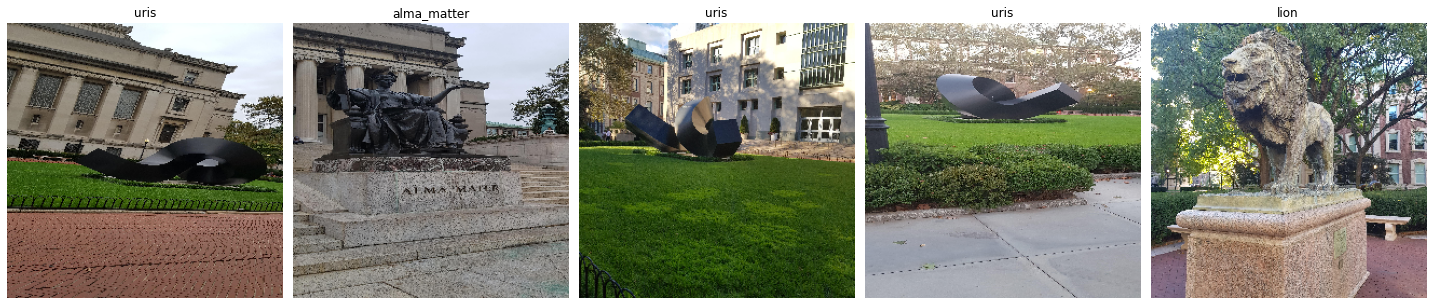

In [94]:
plotImages(sample_training_images, sample_train_labels, inverse_class)

## Models

In [132]:
def plot_metrics(history):
  '''Function to plot accuracy and loss from train and test sets from model history once trained
  Input: model fit object
  Output: One plot for accuracy and one plot for loss
  '''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  #plt.ylim([min(plt.ylim()),1.05])
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  #plt.ylim([0,1.005])
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()

### Simple CNN model

Let's create a small simple CNN model and see its performance

In [ ]:
model_1 = models.Sequential()

model_1.add(layers.Conv2D(32, (3, 3), activation='relu', 
                        input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model_1.add(layers.MaxPooling2D(pool_size=(2,2)))

model_1.add(layers.Conv2D(64, (3, 3), activation='relu', 
                        input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model_1.add(layers.MaxPooling2D(pool_size=(2,2)))

model_1.add(layers.Flatten())
model_1.add(layers.Dense(3, activation='softmax'))

model_1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 246016)            0         
_________________________________________________________________
dense (Dense)                (None, 3)                 738051    
Total params: 757,443
Trainable params: 757,443
Non-trainable params: 0
__________________________________________________

In [ ]:
model_1_history = model_1.fit(
      train_generator,
      steps_per_epoch=5,
      epochs=20,
      validation_data=test_generator)

Epoch 1/20
5/5 [==============================] - 62s 13s/step - loss: 1.2471 - accuracy: 0.5188 - val_loss: 1.1691 - val_accuracy: 0.5067
Epoch 2/20
5/5 [==============================] - 56s 12s/step - loss: 0.8664 - accuracy: 0.6500 - val_loss: 0.9910 - val_accuracy: 0.5333
Epoch 3/20
5/5 [==============================] - 50s 12s/step - loss: 0.8283 - accuracy: 0.6077 - val_loss: 0.7699 - val_accuracy: 0.7467
Epoch 4/20
5/5 [==============================] - 51s 11s/step - loss: 0.5501 - accuracy: 0.8308 - val_loss: 0.6965 - val_accuracy: 0.8000
Epoch 5/20
5/5 [==============================] - 56s 12s/step - loss: 0.4572 - accuracy: 0.8687 - val_loss: 0.6364 - val_accuracy: 0.8067
Epoch 6/20
5/5 [==============================] - 50s 11s/step - loss: 0.4581 - accuracy: 0.8692 - val_loss: 0.6602 - val_accuracy: 0.7733
Epoch 7/20
5/5 [==============================] - 56s 12s/step - loss: 0.3600 - accuracy: 0.8875 - val_loss: 0.5002 - val_accuracy: 0.8267
Epoch 8/20
5/5 [===========

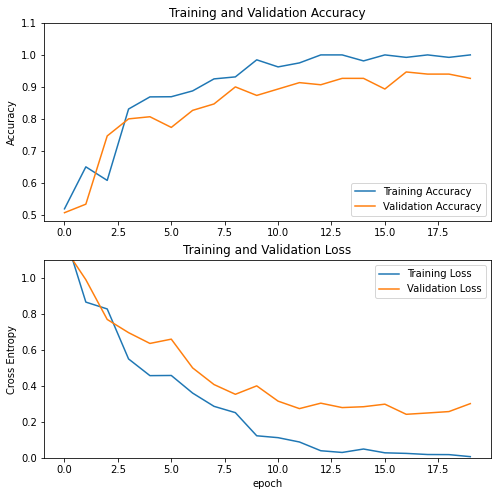

In [71]:
plot_metrics(model_1_history)

Once the model is trained we can make predictions (for simplicity I'll use the test dataset since we don't have a validation set)


The model returns probabilities of belonging to each class, I'll take the maximum to predict the class

In [75]:
class_testlabels = {v:k for k, v in test_generator.class_indices.items()}

In [92]:
sample_test_images, sample_test_labels = next(test_generator)

In [113]:
raw_prediction = model_1.predict(sample_test_images)
sample_prob_prediction = np.max(raw_prediction, axis=1)
sample_class_prediction = np.argmax(raw_prediction, axis=1)

In [115]:
#predictions for sample test
for r,c,p in zip(sample_test_labels[:10], sample_class_prediction[:10], sample_prob_prediction[:10]):
  print("Real label: %s -> Predicted label: %s with %s probability"%(class_testlabels[r],class_testlabels[c], np.round(p,3)))

Real label: lion -> Predicted label: lion with 0.998 probability
Real label: uris -> Predicted label: uris with 0.999 probability
Real label: uris -> Predicted label: uris with 0.882 probability
Real label: alma_matter -> Predicted label: alma_matter with 1.0 probability
Real label: alma_matter -> Predicted label: alma_matter with 0.999 probability
Real label: uris -> Predicted label: alma_matter with 0.772 probability
Real label: alma_matter -> Predicted label: alma_matter with 0.999 probability
Real label: lion -> Predicted label: lion with 0.999 probability
Real label: lion -> Predicted label: lion with 1.0 probability
Real label: alma_matter -> Predicted label: alma_matter with 0.997 probability


Can we do better?

### Transfer learning: VGG16 model

I'll use Keras applications module to load the well known VGG16 model. This allow us to use a far more complex archquitecture as the base of a model without the hassle of having to train it.

I'll use VGG16 model with weights from 'imagenet' and set the layers to not be trainable.

In [116]:
base_model = tf.keras.applications.VGG16(include_top=False, weights ='imagenet',
                                        input_shape = (IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False 

58892288/58889256 [==============================] - 1s 0us/step


Add two top layers to the base model of VGG16 to average last layer and predict:

In [117]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(3, activation='softmax')

In [118]:
# build a new model reusing the pretrained base
tl_model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer])

In [119]:
tl_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1539      
Total params: 14,716,227
Trainable params: 1,539
Non-trainable params: 14,714,688
_________________________________________________________________


From the model summary, we can actually see that the number of parameters that are going to be trained is actually very small. This makes the online deployment of the model on a website to be much more lighter.

Compile and train:

In [120]:
tl_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [121]:
history = tl_model.fit(
      train_generator,
      epochs=20,
      validation_data=test_generator)

Epoch 1/20
15/15 [==============================] - 467s 33s/step - loss: 1.1784 - accuracy: 0.2538 - val_loss: 1.0918 - val_accuracy: 0.4000
Epoch 2/20
15/15 [==============================] - 457s 31s/step - loss: 1.0578 - accuracy: 0.4803 - val_loss: 1.0228 - val_accuracy: 0.5600
Epoch 3/20
15/15 [==============================] - 457s 31s/step - loss: 0.9812 - accuracy: 0.6893 - val_loss: 0.9391 - val_accuracy: 0.8333
Epoch 4/20
15/15 [==============================] - 456s 31s/step - loss: 0.9133 - accuracy: 0.8646 - val_loss: 0.8740 - val_accuracy: 0.8800
Epoch 5/20
15/15 [==============================] - 455s 31s/step - loss: 0.8588 - accuracy: 0.9097 - val_loss: 0.8195 - val_accuracy: 0.9067
Epoch 6/20
15/15 [==============================] - 461s 31s/step - loss: 0.7877 - accuracy: 0.9555 - val_loss: 0.7711 - val_accuracy: 0.9133
Epoch 7/20
15/15 [==============================] - 457s 31s/step - loss: 0.7368 - accuracy: 0.9257 - val_loss: 0.7283 - val_accuracy: 0.9133
Epoch 

We can see an improvement in terms of accuracy for the validation set: 96%. Let's visualize its metrics:

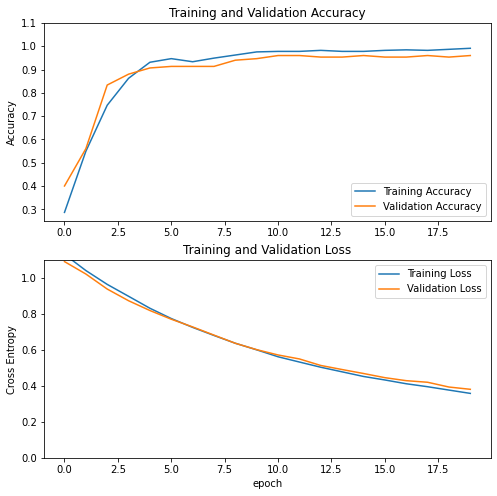

In [122]:
plot_metrics(history)

Can we still keep improving the model?

### Fine tune top layers of base model

We can actually train some of the layers of the base model: bottom layers capture more fundamental shapes and patterns of images, but top layers actually learn features more specific to the dataset in hand.

In [123]:
base_model.trainable = True

In [124]:
#how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 17

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  19


Out of the 19 layers of VGG16, let's train the last 2 layers.

In [125]:
tl_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001/10),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [126]:
tl_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1539      
Total params: 14,716,227
Trainable params: 2,361,347
Non-trainable params: 12,354,880
_________________________________________________________________


From the summary of this new model, we can see that by training the last 2 top layers plus the last layers to predict, the model becomes bigger: from 1,539 to 4,721,155 trainable parameters. Let's train from the last epoch of the previous model:

In [127]:
history_2 = tl_model.fit(
      train_generator,
      epochs=20+20,
      initial_epoch =  history.epoch[-1],
      validation_data=test_generator)

Epoch 20/40
15/15 [==============================] - 469s 32s/step - loss: 0.3634 - accuracy: 0.9767 - val_loss: 0.3147 - val_accuracy: 0.9600
Epoch 21/40
15/15 [==============================] - 467s 32s/step - loss: 0.2713 - accuracy: 0.9957 - val_loss: 0.2575 - val_accuracy: 0.9600
Epoch 22/40
15/15 [==============================] - 467s 31s/step - loss: 0.2130 - accuracy: 0.9981 - val_loss: 0.2146 - val_accuracy: 0.9600
Epoch 23/40
15/15 [==============================] - 468s 31s/step - loss: 0.1776 - accuracy: 0.9864 - val_loss: 0.1868 - val_accuracy: 0.9600
Epoch 24/40
15/15 [==============================] - 465s 31s/step - loss: 0.1412 - accuracy: 0.9920 - val_loss: 0.1577 - val_accuracy: 0.9600
Epoch 25/40
15/15 [==============================] - 466s 31s/step - loss: 0.1118 - accuracy: 0.9975 - val_loss: 0.1361 - val_accuracy: 0.9600
Epoch 26/40
15/15 [==============================] - 465s 31s/step - loss: 0.0943 - accuracy: 0.9968 - val_loss: 0.1246 - val_accuracy: 0.9600

We can see that for this round of training, the accuracy of the test set improves and the train set actually reaches 100% of accuracy.

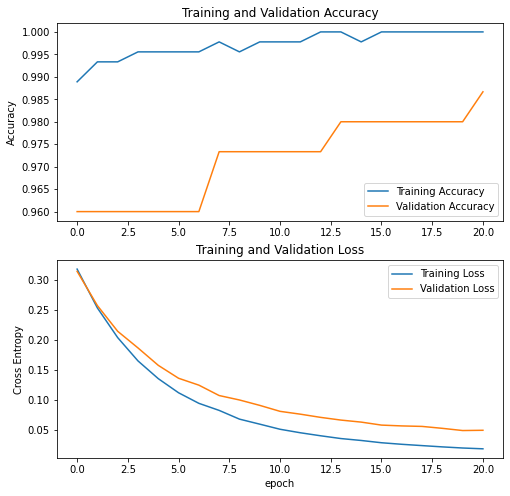

In [133]:
plot_metrics(history_2)

Here, we need to make a decision based on the trade off of accuracy (and overfitting) vs. size of the model. Since the improvement in accuracy is not significantly higher, let's keep the simpler VGG16 base model without trainable layers, having in mind this model would be lighter to load and deploy on a website.

### Save model to Keras h5 format

In [ ]:
tl_model.save("/content/columbiamodel.h5")

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file1 = drive.CreateFile({"title": 'columbiamodel.h5'})
file1.SetContentFile('/content/columbiamodel.h5')
file1.Upload()

### Convert Keras h5 model with js and download to google drive


In [ ]:
!pip install -U tensorflowjs==1.2.6

     |████████████████████████████████| 81kB 6.7MB/s 
     |████████████████████████████████| 109.2MB 115kB/s 
     |████████████████████████████████| 2.8MB 59.7MB/s 
     |████████████████████████████████| 17.3MB 236kB/s 
     |████████████████████████████████| 317kB 60.1MB/s 
     |████████████████████████████████| 491kB 57.2MB/s 
     |████████████████████████████████| 3.2MB 43.1MB/s 
ERROR: umap-learn 0.4.3 has requirement numpy>=1.17, but you'll have numpy 1.16.4 which is incompatible.
ERROR: google-colab 1.0.0 has requirement six~=1.12.0, but you'll have six 1.11.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: six 1.12.0
    Uninstalling six-1.12.0:
      Successfully uninstalled six-1.12.0
  Found existing installation: numpy 1.18.4
    Uninstalli

In [ ]:
!mkdir tfjs_model

In [ ]:
!tensorflowjs_converter --input_format=keras \
/content/columbiamodel.h5 \
/content/tfjs_model

In [ ]:
[f for f in os.listdir('/content/tfjs_model/')]

['group1-shard15of15.bin',
 'group1-shard6of15.bin',
 'group1-shard2of15.bin',
 'group1-shard3of15.bin',
 'group1-shard9of15.bin',
 'group1-shard11of15.bin',
 'group1-shard7of15.bin',
 'group1-shard14of15.bin',
 'group1-shard4of15.bin',
 'group1-shard1of15.bin',
 'group1-shard13of15.bin',
 'group1-shard10of15.bin',
 'group1-shard5of15.bin',
 'model.json',
 'group1-shard12of15.bin',
 'group1-shard8of15.bin']

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

bin_files = [f for f in os.listdir('/content/tfjs_model/')] #binfiles and model.json

for name in bin_files:
  #name = key + '.bin'
  uploaded = drive.CreateFile({'title': name})
  print("Uploading {} file ...".format(name))
  uploaded.SetContentFile('/content/tfjs_model/%s'%name)
  uploaded.Upload()

Uploading group1-shard15of15.bin file ...
Uploading group1-shard6of15.bin file ...
Uploading group1-shard2of15.bin file ...
Uploading group1-shard3of15.bin file ...
Uploading group1-shard9of15.bin file ...
Uploading group1-shard11of15.bin file ...
Uploading group1-shard7of15.bin file ...
Uploading group1-shard14of15.bin file ...
Uploading group1-shard4of15.bin file ...
Uploading group1-shard1of15.bin file ...
Uploading group1-shard13of15.bin file ...
Uploading group1-shard10of15.bin file ...
Uploading group1-shard5of15.bin file ...
Uploading model.json file ...
Uploading group1-shard12of15.bin file ...
Uploading group1-shard8of15.bin file ...


The bin files along with the model in json format are going to be use to deploy the classifier model on a simple website using TensorFlow.js

Visit: https://jacquelinearaya.github.io/classifier to see the model deployed.